In [596]:
import numpy as np
import glob
import cbor2
import json
from fractions import Fraction
import scipy
import random
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pathlib
import copy
import time, hmac, hashlib 
import os

# Reading CBOR

In [484]:
TRAINING_DATA_PATH = "data/03-19-2021/training"
TESTING_DATA_PATH = "data/03-19-2021/testing"

In [485]:
train_fn = glob.glob(TRAINING_DATA_PATH+"/*")

In [486]:
train_fn[657]

'data/03-19-2021/training\\D.1ts56rd5.ingestion-57674656cc-4llv6.cbor'

In [487]:
with open(train_fn[657], 'rb') as f:
    data = cbor2.load(f)

In [488]:
sample_data = np.array(data["payload"]["values"])

In [489]:
def plot_accelerometer_data(data):
    fig = go.Figure(layout=go.Layout(title="Accelerometer data"))

    axes_names = ["X", "Y", "Z"]
    colors = ["red", "green", "blue"]

    x = np.arange(0, 200, 1)

    for feature, axis_name, color in zip(data.T, axes_names, colors):
        fig.add_trace(go.Scatter(x=x, y=feature, mode='lines', name=axis_name, opacity=0.7,
                     line =dict(color=color)))

    fig.show()

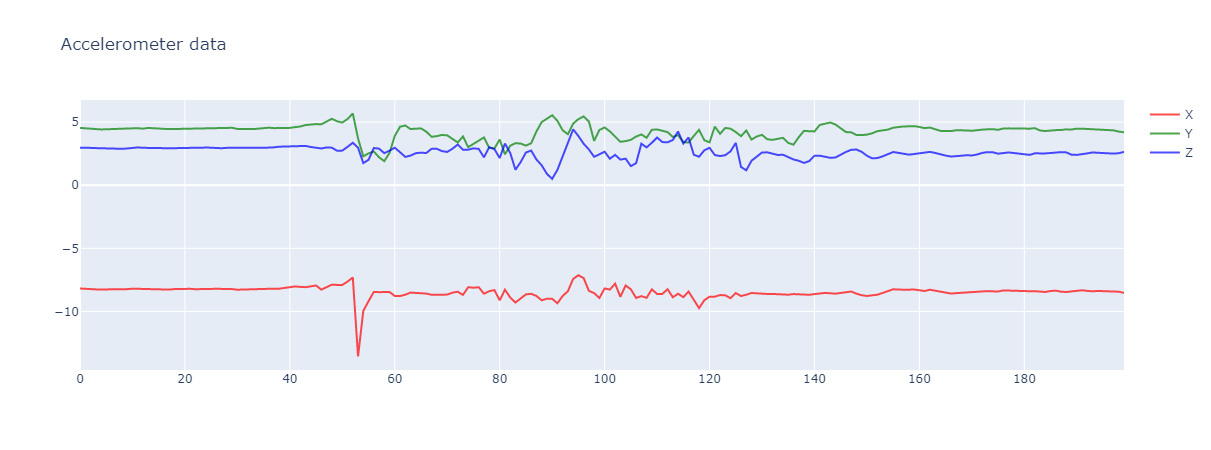

In [490]:
plot_accelerometer_data(sample_data)

# Time stretching

In [491]:
ratios = np.arange(0.7, 1.3, 0.05)


for ratio in ratios:
    frac = Fraction(ratio).limit_denominator(100)
    num, den = frac.as_integer_ratio()
    print("Ratio: {:.2f}, Approx. Fraction {}, Actual ratio: {:.2f}".format(ratio, frac, num/den))

Ratio: 0.70, Approx. Fraction 7/10, Actual ratio: 0.70
Ratio: 0.75, Approx. Fraction 3/4, Actual ratio: 0.75
Ratio: 0.80, Approx. Fraction 4/5, Actual ratio: 0.80
Ratio: 0.85, Approx. Fraction 17/20, Actual ratio: 0.85
Ratio: 0.90, Approx. Fraction 9/10, Actual ratio: 0.90
Ratio: 0.95, Approx. Fraction 19/20, Actual ratio: 0.95
Ratio: 1.00, Approx. Fraction 1, Actual ratio: 1.00
Ratio: 1.05, Approx. Fraction 21/20, Actual ratio: 1.05
Ratio: 1.10, Approx. Fraction 11/10, Actual ratio: 1.10
Ratio: 1.15, Approx. Fraction 23/20, Actual ratio: 1.15
Ratio: 1.20, Approx. Fraction 6/5, Actual ratio: 1.20
Ratio: 1.25, Approx. Fraction 5/4, Actual ratio: 1.25
Ratio: 1.30, Approx. Fraction 13/10, Actual ratio: 1.30


In [492]:
def stretch(data, ratio):
    n_timesteps, n_features = data.shape
    num, den = Fraction(ratio).limit_denominator(100).as_integer_ratio()

    # Resampling
    resampled = scipy.signal.resample_poly(data, num, den, axis=0)
    new_n_timesteps, _ = resampled.shape
    
    #Padding
    if new_n_timesteps < n_timesteps:
        n_pads = n_timesteps - new_n_timesteps
        padded = np.empty_like(data)
        padded[:n_pads//2] = data[0]
        padded[n_pads//2 : -n_pads//2] = resampled
        padded[-n_pads//2:] = data[-1]
    else:
        padded = resampled
    
    # Windowing
    mid_point = padded.shape[0] // 2
    stretched = padded[mid_point - n_timesteps//2 : mid_point + n_timesteps//2]

    return stretched

### Original data

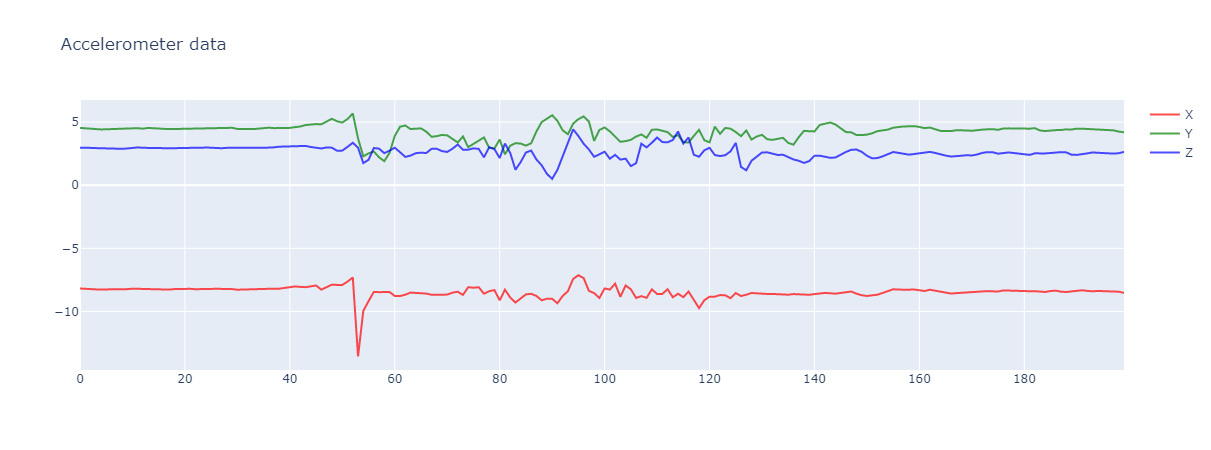

In [493]:
plot_accelerometer_data(sample_data)

### Stretched data (window centered)

In [494]:
stretched_data = stretch(sample_data, 1.3)
stretched_data.shape

(200, 3)

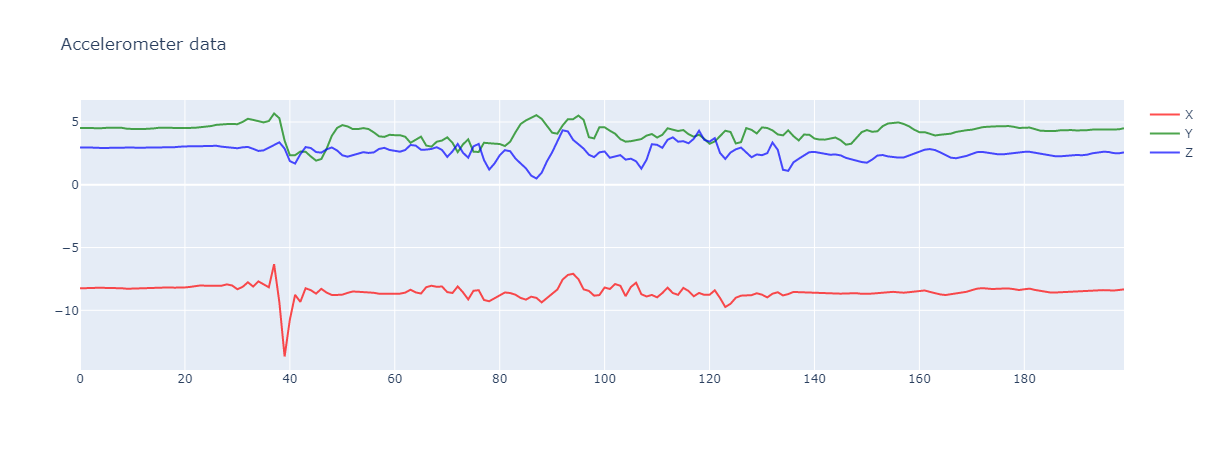

In [495]:
plot_accelerometer_data(stretched_data)

# Time shift

In [496]:
def shift(data, num):
    result = np.empty_like(data)
    if num > 0:
        fill_value = data[0]
        result[:num] = fill_value
        result[num:] = data[:-num]
    elif num < 0:
        fill_value = data[-1]
        result[num:] = fill_value
        result[:num] = data[-num:]
    else:
        result[:] = data
    return result 

### Orignal data 

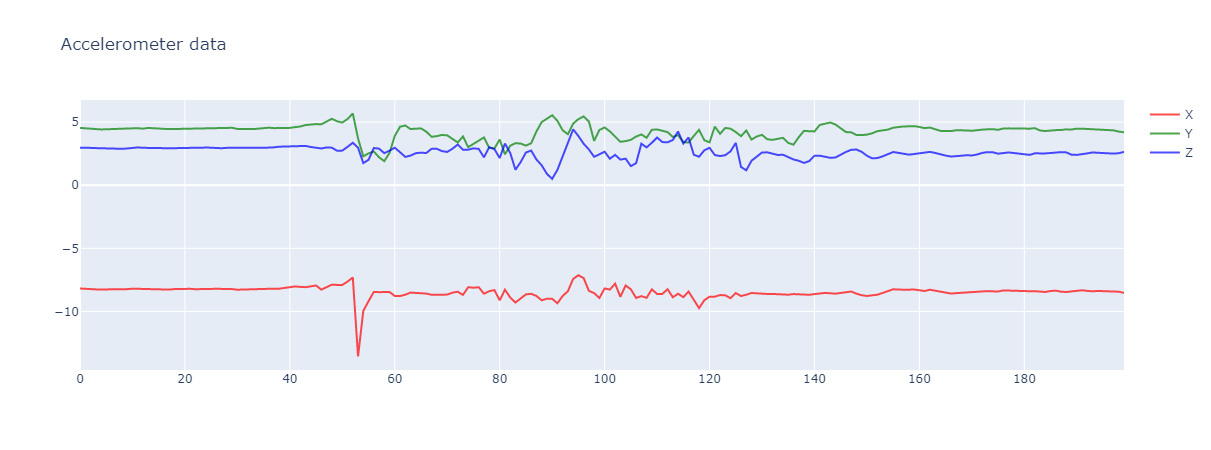

In [497]:
plot_accelerometer_data(sample_data)

### Shifted data

In [498]:
shifted_data = shift(sample_data, 20)
shifted_data.shape

(200, 3)

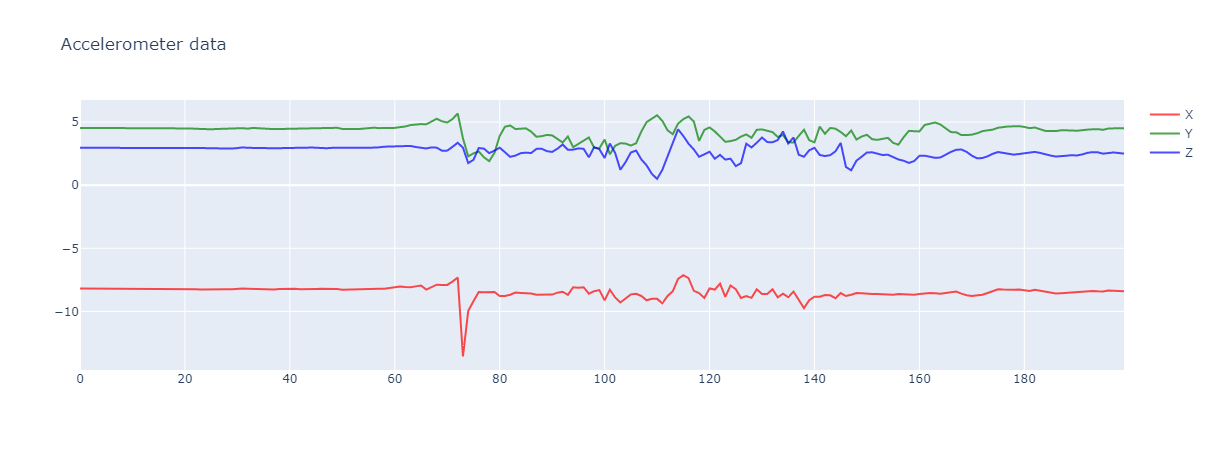

In [499]:
plot_accelerometer_data(shifted_data)

# Random transformation function 

In [536]:
def random_transformation(data):
    ratios = np.arange(0.7, 1.3, 0.05)
    shift_nums = np.arange(-30, 30 + 1 , 10)
    
    ratio = random.choice(ratios)
    shift_num = random.choice(shift_nums)
    #print("ratio: {:.2f}, shift_num: {}".format(ratio, shift_num) )
    
    data = shift(data, shift_num)
    data = stretch(data, ratio)
    
    return data

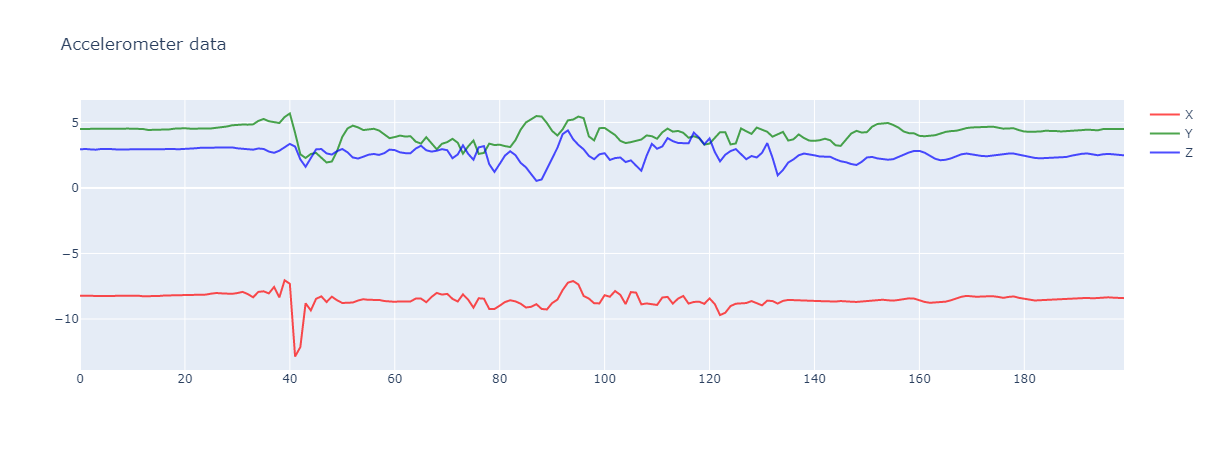

In [537]:
random_transformed_data = random_transformation(sample_data)
plot_accelerometer_data(random_transformed_data)

# Creating artificial dataset 

In [538]:
HMAC_KEY = 'ce64d7e1cf722db6999220c18f58f80f'

In [615]:
def sign_data(data):
    """data is a dict"""
    #empty signature
    emptySignature = ''.join(['0'] * 64)
    data['signature'] = emptySignature
    # encode in JSON
    encoded = json.dumps(data)
    # sign message
    signature = hmac.new(bytes(HMAC_KEY, 'utf-8'), msg = encoded.encode('utf-8'), digestmod = hashlib.sha256).hexdigest()
    # set the signature again in the message
    data['signature'] = signature
    return data


def create_artificial_samples(filepath, n_samples):
    """Create n_samples additional samples """
    
    with open(filepath, 'rb') as f:
        org_data = cbor2.load(f)
        
    fp = pathlib.Path(filepath)
    new_filename = (fp.stem +"_0") + fp.suffix
    
    samples = [org_data]
    filenames = [new_filename]
    for i in range(n_samples):
        new_filename = (fp.stem +"_{}".format(i+1)) + fp.suffix
        data_dict = copy.deepcopy(org_data)
        values = np.array(data_dict["payload"]["values"])
        new_values = random_transformation(values)
        data_dict["payload"]["values"] = new_values.tolist()
        signed_data_dict = sign_data(data_dict)
        
        samples.append(signed_data_dict)
        filenames.append(new_filename)
    
    return samples, filenames


def create_artificial_dataset(samples_folder, new_folder, n_samples, seed=42):
    """ TODO """
    
    random.seed(seed)
    
    # Find all samples in the folder
    filepaths = glob.glob(samples_folder+"/*")
    
    if not os.path.exists(new_folder):
        os.makedirs(new_folder)
        
    for filepath in filepaths:
        # Create artificial samples
        samples, filenames = create_artificial_samples(filepath, n_samples)
        
        for sample, filename in zip(samples, filenames):
            new_filepath = new_folder + "/" + filename
            
            # save file
            with open(new_filepath, 'wb') as fp:
                cbor2.dump(sample, fp)

    

In [618]:
TRAINING_DATA_PATH = "data/03-19-2021/training"
TESTING_DATA_PATH = "data/03-19-2021/testing"

AUGMENTED_TRAINING_DATA_PATH = "data/augmented/training"
AUGMENTED_TESTING_DATA_PATH = "data/augmented/testing"

N_SAMPLES = 5

In [617]:
create_artificial_dataset(TRAINING_DATA_PATH, AUGMENTED_TRAINING_DATA_PATH, N_SAMPLES)

In [620]:
create_artificial_dataset(TESTING_DATA_PATH, AUGMENTED_TESTING_DATA_PATH, N_SAMPLES)